In [149]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Proof-of-Concept Model
## Data Engineering
1. Web-scaping for game results, goal scorers, formation
2. Can I get info on who is defending goal?
3. Can I get info on type of goal (fast break, counterattack, slow buildup, set piece, penalty)?
4. How to get goal-blocked info?  Defensive wins? ... Whoscored.com
    - Need to look at https://github.com/ziplokk1/incapsula-cracker-py3
    - https://stackoverflow.com/questions/55549974/what-are-these-different-errors-im-getting-when-scraping-using-beautifulsoup


## Import Libraries

In [228]:
import requests
from bs4 import BeautifulSoup
import itertools
import difflib
from time import time
import pickle

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, accuracy_score
from scipy.optimize import differential_evolution, basinhopping

import lightgbm as lgbm
import xgboost as xgb
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

import seaborn as sns
import matplotlib.pyplot as plt


## Pre-processing

1. Want to get dataframe with one-row per goal scored (or one row per match?)
2. Merge goal scoring information with FIFA database info

In [151]:
# match_id .. homeplayer1_stat1 ... homeplayer1_stat2 ...--> awayplayer11_statZZ ... homegoals_scored .. awaygoals_scored


In [152]:
# Need to create a db of matches for a season (20 teams * 38/2 games/team) = 380 matches
# Get starting 11 for each team for all games
# Merge/melt operation to get player data integrated
# Final two columns are homegoals_scored and awaygoals_scored

### Read-in Data Sources

In [154]:
# EPL Results
# epl_results = pd.read_csv('../input/english-premier-league-results/results.csv')

# Starting 11 Data (need to scrape from Transfermarkt)

# 1. Scrape urls for all 380 matches
# 2. For each of these urls, scrape ... starting 11, goals, type, formation

running = 'home'

# Fifa 19 Player Stats
if running == 'kaggle':
    path = '../input/fifa19/'
    df_fifa19 = pd.read_csv(path+'data.csv')
    print(df_fifa19.shape)
    len(df_fifa19.ID.unique())

# Home Computer
if running == 'home':
    df_fifa19 = pd.read_csv('data.csv')
    print(df_fifa19.shape)
    

# Will want to key off the Fifa player ID when merging dataframes

(18207, 89)


### Extract List of Hyperlinks for Each Match of 2018-19 Season

In [155]:
# Load the webpage
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

page = 'https://www.transfermarkt.com/premier-league/gesamtspielplan/wettbewerb/GB1/saison_id/2018'
pageTree = requests.get(page, headers=headers)
pageSoup = BeautifulSoup(pageTree.content, 'html.parser')

# Locate the Data and Extract it
links = pageSoup.find_all('a', {'class': 'ergebnis-link'})

hlinks = []
for idx, link in enumerate(links):
    
    # Get Hyperlink ID for each match
    match_id = str(links[idx]).split(' ')[3].split('"')[-2]
    
    # Reconstruct full hyperlink
    hlink = 'https://www.transfermarkt.com/spielbericht/index/spielbericht/{}'.format(match_id)
    hlinks.append(hlink)
    
print(len(hlinks))

380


### Scrape Data for Each Match

In [156]:
def scrape_matchdata(hlink):
    # Load the webpage
    headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

    page = hlink
    pageTree = requests.get(page, headers=headers)
    pageSoup = BeautifulSoup(pageTree.content, 'html.parser')

    match_id = hlink.split('/')[-1]
    
    # Locate the Data and Extract it
    
    pagetitle = pageSoup.find_all('meta', {'property': 'og:title'})

    home = str(pagetitle).split(' - ')[0].split('="')[-1]
    away = str(pagetitle).split(' - ')[1].split(',')[0]
    
    formation = pageSoup.find_all('div', {'class': 'large-7 aufstellung-vereinsseite columns small-12 unterueberschrift aufstellung-unterueberschrift'})
    home_formation = str(formation[0]).split('\t')[-4].split(': ')[1]
    away_formation = str(formation[1]).split('\t')[-4].split(': ')[1]
    
    players = pageSoup.find_all('span', {'class': 'aufstellung-rueckennummer-name spielprofil_tooltip'})
    starters = [str(players[x]).split('>')[-3].split('<')[0] for x, idx in enumerate(players)]
    
    result = pageSoup.find_all('div', {'class': 'sb-endstand'})
    scoreline = str(result[0]).split('<div')[-2].split('\t')[-1]
    
    home_goals = int(scoreline.split(':')[0])
    away_goals = int(scoreline.split(':')[1])
    
    return match_id, home, away, home_formation, away_formation, starters[:11], starters[11:], home_goals, away_goals


### Build Dataframe for all 380 Matches

In [167]:
mode = 'load_data_from_pkl'
# mode = 're-scrape'

if mode == 'load_data_from_pkl':
    
    data = pickle.load(open('scraped_data.p','rb'))

else:

    l_match_id = []
    l_home = []
    l_away = []
    l_home_formation = []
    l_away_formation = []
    l_home_11 = []
    l_away_11 = []
    l_home_goals = []
    l_away_goals = []

    for idx, link in enumerate(hlinks):
        match_id, home, away, home_formation, away_formation, home_11, away_11, home_goals, away_goals = scrape_matchdata(link)

        l_match_id.append(match_id)
        l_home.append(home)
        l_away.append(away)
        l_home_formation.append(home_formation)
        l_away_formation.append(away_formation)
        l_home_11.append(home_11)
        l_away_11.append(away_11)
        l_home_goals.append(home_goals)
        l_away_goals.append(away_goals)

        if idx % 40 == 0:
            print(idx)

    data = pd.DataFrame({'match_id':l_match_id,
                  'home':l_home,
                  'away':l_away,
                  'home_formation':l_home_formation,
                  'away_formation':l_away_formation,
                  'home_11':l_home_11,
                  'away_11':l_away_11,
                  'home_goals':l_home_goals,
                  'away_goals':l_away_goals})
    
    # Save data to pickle file for reloading later
#     pickle.dump(data,open('scraped_data.p','wb'))
    with open('scraped_data.p', 'wb') as f:
        pickle.dump(data, f)

    

In [168]:
data = pd.DataFrame({'match_id':l_match_id,
              'home':l_home,
              'away':l_away,
              'home_formation':l_home_formation,
              'away_formation':l_away_formation,
              'home_11':l_home_11,
              'away_11':l_away_11,
              'home_goals':l_home_goals,
              'away_goals':l_away_goals})

for i in range(1,12):
    
    data['home_p'+str(i)] = data['home_11'].apply(lambda x: x[i-1])
    data['away_p'+str(i)] = data['away_11'].apply(lambda x: x[i-1])

### Merge Fifa stats with Match Data
- First need to get consistent team names to prep for an effective merge
- Second need to get consistent player names ... use Fifa since it has first name as well

In [169]:
sorted(list(set(data.home).difference(set(list(df_fifa19.Club.unique())))))

['Brighton &amp; Hove Albion']

In [170]:

# Clean Data for Steve Cook
data.home_p3.loc[data.home_p3 == 'Cook'] = 'Cook_s'
data.home_p4.loc[data.home_p4 == 'Cook'] = 'Cook_s'
data.away_p3.loc[data.away_p3 == 'Cook'] = 'Cook_s'
data.away_p4.loc[data.away_p4 == 'Cook'] = 'Cook_s'
data.away_p5.loc[data.away_p5 == 'Cook'] = 'Cook_s'

# Clean Data for Lewis Cook
data.home_p7.loc[data.home_p7 == 'Cook'] = 'Cook_l'
data.away_p7.loc[data.away_p7 == 'Cook'] = 'Cook_l'
data.away_p8.loc[data.away_p8 == 'Cook'] = 'Cook_l'
data.away_p10.loc[data.away_p10 == 'Cook'] = 'Cook_l'

# Clean Data for David Silva
data.home_p6.loc[data.home_p6 == 'Silva'] = 'Silva_d'
data.home_p7.loc[data.home_p7 == 'Silva'] = 'Silva_d'
data.home_p8.loc[data.home_p8 == 'Silva'] = 'Silva_d'
data.away_p7.loc[data.away_p7 == 'Silva'] = 'Silva_d'
data.away_p8.loc[data.away_p8 == 'Silva'] = 'Silva_d'

# Clean Data for Bernardo Silva
data.home_p10.loc[data.home_p10 == 'Silva'] = 'Silva_b'
data.home_p11.loc[data.home_p11 == 'Silva'] = 'Silva_b'
data.away_p10.loc[data.away_p10 == 'Silva'] = 'Silva_b'
data.away_p11.loc[data.away_p11 == 'Silva'] = 'Silva_b'


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [171]:
data = data.replace('Brighton &amp; Hove Albion', 'Brighton & Hove Albion')

team_names_to_clean = sorted(list(set(data.home).difference(set(list(df_fifa19.Club.unique())))))

team_name_clean_dict = {'Bournemouth':team_names_to_clean[0],
                        'Arsenal':team_names_to_clean[1],
                        'Burnley':team_names_to_clean[2],
                        'Chelsea':team_names_to_clean[3],
                        'Everton':team_names_to_clean[4],
                        'Fulham':team_names_to_clean[5],
                        'Liverpool':team_names_to_clean[6],
                        'Southampton':team_names_to_clean[7],
                        'Watford':team_names_to_clean[8]}

IndexError: list index out of range

In [172]:
df_fifa19 = df_fifa19.replace(team_name_clean_dict)
df_fifa19['Name'] = df_fifa19.Name.str.lower()

In [173]:
data.head()


,match_id,home,away,home_formation,away_formation,home_11,away_11,home_goals,away_goals,home_p1,...,home_p7,away_p7,home_p8,away_p8,home_p9,away_p9,home_p10,away_p10,home_p11,away_p11
0,3050172,Manchester United,Leicester City,4-1-4-1,4-4-2 double 6,"[de Gea, Bailly, Darmian, Lindelöf, Shaw, Fred...","[Schmeichel, Chilwell, Maguire, Morgan, Pereir...",2,1,de Gea,...,Mata,Maddison,Pereira,Ndidi,Pogba,Silva,Rashford,Gray,Sánchez,Iheanacho
1,3050173,Newcastle United,Tottenham Hotspur,4-4-1-1,4-3-2-1,"[Dubravka, Clark, Dummett, Lascelles, Yedlin, ...","[Lloris, Aurier, Davies, Sánchez, Vertonghen, ...",1,2,Dubravka,...,Kenedy,Dier,Ritchie,Eriksen,Shelvey,Sissoko,Joselu,Kane,Pérez,Lucas Moura
2,3050168,AFC Bournemouth,Cardiff City,4-4-2 double 6,4-1-4-1,"[Begovic, Aké, Cook, Daniels, Smith, Brooks, G...","[Etheridge, Bamba, Bennett, Ecuele Manga, Morr...",2,0,Begovic,...,Gosling,Paterson,Surman,Ralls,Fraser,Reid,King,Hoilett,Wilson,Mendez-Laing
3,3050169,Fulham FC,Crystal Palace,4-3-3 Attacking,4-4-2,"[Fabri, Bryan, Chambers, Christie, Le Marchand...","[Hennessey, Sakho, Schlupp, Tomkins, Wan-Bissa...",0,2,Fabri,...,McDonald,McArthur,Seri,Milivojevic,Sessegnon,Benteke,Mitrovic,Townsend,Schürrle,Zaha
4,3050170,Huddersfield Town,Chelsea FC,3-5-2 flat,4-3-3 Attacking,"[Hamer, Hadergjonaj, Kongolo, Löwe, Schindler,...","[Kepa, Alonso, Azpilicueta, David Luiz, Rüdige...",0,3,Hamer,...,Billing,Jorginho,Hogg,Kanté,Mooy,Morata,Pritchard,Pedro,Mounié,Willian


In [174]:
# Steps
# 1. Get list of all unique player names from EPL df
# 2. Get length of that list
# 3. Try to search for each of the players in the Fifa19 df
# 4. Sum up the ones that come back with a result, and compare that to the length of the EPL list
# 5. Alternatively build a list of the successful searches and do a difference op to get the unsuccessful ones

list2d = [list(data['home_p'+str(i)].unique()) + list(data['away_p'+str(i)].unique()) for i in range(1,12)]
merged = list(itertools.chain.from_iterable(list2d))

# Use set to remove duplicates
player_list = list(set(merged))

player_club_list = [list(zip(data['home_p'+str(i)].values, data.home.values)) + list(zip(data['away_p'+str(i)].values, data.away.values)) for i in range(1,12)]
player_club_list_merged = list(itertools.chain.from_iterable(player_club_list))
player_club_list_merged = sorted(list(set(player_club_list_merged)))

print('Player List size is',len(player_list))
print('Player Club List size is',len(player_club_list_merged))

Player List size is 443
Player Club List size is 463


In [175]:
player_club_list_merged

[('Agüero', 'Manchester City'),
 ('Aké', 'AFC Bournemouth'),
 ('Albrighton', 'Leicester City'),
 ('Alderweireld', 'Tottenham Hotspur'),
 ('Alexander-.', 'Liverpool FC'),
 ('Alisson', 'Liverpool FC'),
 ('Alli', 'Tottenham Hotspur'),
 ('Almirón', 'Newcastle United'),
 ('Alonso', 'Chelsea FC'),
 ('Amartey', 'Leicester City'),
 ('Andone', 'Brighton & Hove Albion'),
 ('Antonio', 'West Ham United'),
 ('Armstrong', 'Southampton FC'),
 ('Arnautovic', 'West Ham United'),
 ('Arter', 'Cardiff City'),
 ('Atsu', 'Newcastle United'),
 ('Aubameyang', 'Arsenal FC'),
 ('Aurier', 'Tottenham Hotspur'),
 ('Austin', 'Southampton FC'),
 ('Ayew', 'Crystal Palace'),
 ('Ayité', 'Fulham FC'),
 ('Azpilicueta', 'Chelsea FC'),
 ('Babel', 'Fulham FC'),
 ('Bacuna', 'Cardiff City'),
 ('Bacuna', 'Huddersfield Town'),
 ('Bailly', 'Manchester United'),
 ('Baines', 'Everton FC'),
 ('Balbuena', 'West Ham United'),
 ('Balogun', 'Brighton & Hove Albion'),
 ('Bamba', 'Cardiff City'),
 ('Bardsley', 'Burnley FC'),
 ('Barkley',

In [176]:
# df_fifa19.Name.loc[df_fifa19.Name.str.contains('Fosu-Mensah') == True]
# df_fifa19.iloc[1213].Club

exact_match = []
close_matches = []
failed_search = []
multiple_records = []
alternates = []
name_id_dict = {}

for name, club in player_club_list_merged:
    
    result = df_fifa19.Name.loc[(df_fifa19.Name.str.contains(name.lower()) == True) & (df_fifa19.Club == club)]
    
    # If result returns only one exact match
    if result.shape[0] == 1:
        exact_match.append(result.values[0])
        name_id_dict.update({(name, club): int(df_fifa19.ID.loc[(df_fifa19.Name.str.contains(name.lower()) == True) & (df_fifa19.Club == club)].values)})
    
    # Else if no exact matches
    elif result.shape[0] == 0:
        
        # Get close spellings of name only
        closest_matches = difflib.get_close_matches(name, list(df_fifa19.Name.unique()))
        
        # If multiple close spellings
        if len(closest_matches) > 0:
            
            # Check for same team to reduce further
            match = df_fifa19.loc[(df_fifa19.Name.isin(closest_matches)) & (df_fifa19.Club == club)].Name
            
            # If one one match for close spelling and same team
            if match.shape[0] == 1:
                exact_match.append(match.values[0])
                name_id_dict.update({(name, club): int(df_fifa19.ID.loc[(df_fifa19.Name.isin(closest_matches)) & (df_fifa19.Club == club)].values)})
            
            # Else if no close spellings that match team
            elif match.shape[0] == 0:
                failed_search.append(name)
            
            else:
                alternates.append([name, closest_matches])
        
        # Else no close spellings
        else:
            failed_search.append(name)
    
    # Else multiple matches for same team and name
    else:
        
        multiple_records.append([name, list(result.values)])


In [177]:
name_id_dict

{('Agüero', 'Manchester City'): 153079,
 ('Aké', 'AFC Bournemouth'): 208920,
 ('Albrighton', 'Leicester City'): 183130,
 ('Alderweireld', 'Tottenham Hotspur'): 184087,
 ('Alexander-.', 'Liverpool FC'): 231281,
 ('Alisson', 'Liverpool FC'): 212831,
 ('Alli', 'Tottenham Hotspur'): 211117,
 ('Alonso', 'Chelsea FC'): 192638,
 ('Amartey', 'Leicester City'): 212883,
 ('Andone', 'Brighton & Hove Albion'): 225018,
 ('Antonio', 'West Ham United'): 190717,
 ('Armstrong', 'Southampton FC'): 202282,
 ('Arnautovic', 'West Ham United'): 184200,
 ('Arter', 'Cardiff City'): 184469,
 ('Atsu', 'Newcastle United'): 205601,
 ('Aubameyang', 'Arsenal FC'): 188567,
 ('Aurier', 'Tottenham Hotspur'): 197853,
 ('Austin', 'Southampton FC'): 195671,
 ('Ayew', 'Crystal Palace'): 197756,
 ('Ayité', 'Fulham FC'): 188271,
 ('Azpilicueta', 'Chelsea FC'): 184432,
 ('Bacuna', 'Huddersfield Town'): 226677,
 ('Bailly', 'Manchester United'): 225508,
 ('Baines', 'Everton FC'): 163631,
 ('Balbuena', 'West Ham United'): 22822

In [178]:
# To clean, need to manually create a dict that connects names to proper fifa_idx
manual_id_dict = {('Almirón', 'Newcastle United'): 230977, ('Babel', 'Fulham FC'):157301, ('Bacuna', 'Cardiff City'):226677,
                  ('Barnes', 'Leicester City'): 234742, ('Batshuayi', 'Crystal Palace'): 204529,
                  ('Begovic', 'AFC Bournemouth'): 172723, ('Chicharito', 'West Ham United'): 178224,
                  ('Clyne', 'AFC Bournemouth'): 190456, ('Coleman', 'Huddersfield Town'): 180216,
                  ('Ecuele Manga', 'Cardiff City'): 188270, ('Gorenc-Sta.', 'Huddersfield Town'): 226129,
                  ('Grant', 'Huddersfield Town'): 225668, ('Higuaín', 'Chelsea FC'): 167664,
                  ('King', 'AFC Bournemouth'): 186578, ('Kovacic', 'Chelsea FC'): 207410,
                  ('Matic', 'Manchester United'): 191202,
                  ('Mepham', 'AFC Bournemouth'): 233201, ('Mitrovic', 'Fulham FC'): 215716,  ('Muto', 'Newcastle United'): 228717,
                  ('Niasse', 'Cardiff City'): 208339, ('Nordtveit', 'Fulham FC'): 182888,
                  ('Otto', 'Wolverhampton Wanderers'): 210455, ('Puncheon', 'Huddersfield Town'): 152514,
                  ('Sims', 'Southampton FC'): 218660, ('Soares', 'Southampton FC'): 227476,
                  ('Solanke', 'AFC Bournemouth'): 225539,  ('Tielemans', 'Leicester City'): 216393,
                  ('Townsend', 'Crystal Palace'): 203751, ('Traoré', 'Wolverhampton Wanderers'): 225151,
                  ('Zanka', 'Huddersfield Town'): 183491}

unclaimed_dict = {('Cairney', 'Fulham FC'): np.NaN, ('Capoue', 'Watford FC'): np.NaN, ('Cech', 'Arsenal FC'): np.NaN,
                  ('Deeney', 'Watford FC'): np.NaN, ('Duffy', 'Brighton & Hove Albion'): np.NaN,
                  ('Evans', 'Leicester City'): np.NaN, ('Foster', 'Watford FC'): np.NaN, 
                  ('Greenwood', 'Manchester United'): np.NaN, ('Johnson', 'West Ham United'): np.NaN,
                  ('Kabasele', 'Watford FC'): np.NaN, ('Mooy', 'Huddersfield Town'): np.NaN,
                  ('Nasri', 'West Ham United'): np.NaN, ('Ramsay', 'Southampton FC'): np.NaN,
                  ('Rowe', 'Huddersfield Town'): np.NaN, ('Travers', 'AFC Bournemouth'): np.NaN}

mult_records_dict = {('Cook_l', 'AFC Bournemouth'): 224294, ('Cook_s', 'AFC Bournemouth'): 193011, 
                     ('Fernández', 'Newcastle United'): 201988, ('Murphy', 'Cardiff City'): 206083,
                     ('Sessegnon', 'Fulham FC'): 235883, ('Silva_b', 'Manchester City'): 218667,
                     ('Silva_d', 'Manchester City'): 168542, ('Son', 'Tottenham Hotspur'): 200104,
                     ('Wood', 'Burnley FC'): 192123}



### Need Imputation Strategy for missing plyaers to avoid large loss of data after data propagates

In [179]:
# Tom Cairney
# Etienne Capoue
# Petr Cech - older GK, elite
# Troy Deeney
# Shane Duffy
# Johnny Evans
# Ben Foster older GK, avg
# Mason Greenwood
# Adam Johnson
# Christian Kabasele
# Aaron Mooy
# Samir Nasri
# Kayne Ramsay
# Aaron Rowe
# Mark Travers - gk


In [180]:
len(manual_id_dict) + len(unclaimed_dict) + len(mult_records_dict) + len(name_id_dict)

len(player_club_list_merged)

463

In [181]:
def find_team(name, df):
    
    search_cols = ['home_p'+str(x) for x in range(1,12)] + ['away_p'+str(x) for x in range(1,12)]
    return df[(df[search_cols] == name).any(1)].home.describe().top

def id_mapping(df, col):
    
    orig_col = col[:-3]
    
    if col.startswith('home'):
        key = (df[orig_col], df.home)
    
    else:
        key = (df[orig_col], df.away)
    
    if key in name_id_dict:
        return int(name_id_dict[key])
    
    elif key in manual_id_dict:
        return int(manual_id_dict[key])
    
    elif key in mult_records_dict:
        return int(mult_records_dict[key])
    
    else:
        return unclaimed_dict[key]
    

### Clean Data for Player Names that are not found or have multiple results
- Map ID to dataframe
- Use ID to merge Fifa 19 Data

In [182]:
# Create column placeholders for player ID
id_cols = ['home_p{}_id'.format(i) for i in range(1,12)] + ['away_p{}_id'.format(i) for i in range(1,12)]

for col in id_cols:
    
    data[col] = data.apply(id_mapping, col=col, axis=1)


In [183]:
data.head()

,match_id,home,away,home_formation,away_formation,home_11,away_11,home_goals,away_goals,home_p1,...,away_p2_id,away_p3_id,away_p4_id,away_p5_id,away_p6_id,away_p7_id,away_p8_id,away_p9_id,away_p10_id,away_p11_id
0,3050172,Manchester United,Leicester City,4-1-4-1,4-4-2 double 6,"[de Gea, Bailly, Darmian, Lindelöf, Shaw, Fred...","[Schmeichel, Chilwell, Maguire, Morgan, Pereir...",2,1,de Gea,...,229984,203263.0,136113.0,210243.0,212883.0,220697.0,226790.0,184826.0,220633.0,225719.0
1,3050173,Newcastle United,Tottenham Hotspur,4-4-1-1,4-3-2-1,"[Dubravka, Clark, Dummett, Lascelles, Yedlin, ...","[Lloris, Aurier, Davies, Sánchez, Vertonghen, ...",1,2,Dubravka,...,197853,205923.0,220793.0,172871.0,211117.0,202335.0,190460.0,183394.0,202126.0,200949.0
2,3050168,AFC Bournemouth,Cardiff City,4-4-2 double 6,4-1-4-1,"[Begovic, Aké, Cook, Daniels, Smith, Brooks, G...","[Etheridge, Bamba, Bennett, Ecuele Manga, Morr...",2,0,Begovic,...,172425,190430.0,188270.0,187033.0,169575.0,210724.0,204464.0,203502.0,189462.0,194964.0
3,3050169,Fulham FC,Crystal Palace,4-3-3 Attacking,4-4-2,"[Fabri, Bryan, Chambers, Christie, Le Marchand...","[Hennessey, Sakho, Schlupp, Tomkins, Wan-Bissa...",0,2,Fabri,...,183285,200759.0,173546.0,229880.0,186190.0,171972.0,206304.0,184111.0,203751.0,198717.0
4,3050170,Huddersfield Town,Chelsea FC,3-5-2 flat,4-3-3 Attacking,"[Hamer, Hadergjonaj, Kongolo, Löwe, Schindler,...","[Kepa, Alonso, Azpilicueta, David Luiz, Rüdige...",0,3,Hamer,...,192638,184432.0,179944.0,205452.0,199189.0,205498.0,215914.0,201153.0,189505.0,180403.0


In [184]:
gk_attribs = ['ID', 'Overall', 'Potential', 'Special',
       'International Reputation', 'ShortPassing', 'LongPassing', 'BallControl',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']

p_attribs = ['ID', 'Overall', 'Potential', 'Special', 'International Reputation', 'Weak Foot',
             'Skill Moves', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
             'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed',
             'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
             'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking',
             'StandingTackle', 'SlidingTackle']


### Creating columns for each of the Fifa attributes in advance of merge

In [185]:
gk_cols = ['{}_home_p1'.format(x) for x in gk_attribs[1:]] + ['{}_away_p1'.format(x) for x in gk_attribs[1:]]
gk_cols

['Overall_home_p1',
 'Potential_home_p1',
 'Special_home_p1',
 'International Reputation_home_p1',
 'ShortPassing_home_p1',
 'LongPassing_home_p1',
 'BallControl_home_p1',
 'GKDiving_home_p1',
 'GKHandling_home_p1',
 'GKKicking_home_p1',
 'GKPositioning_home_p1',
 'GKReflexes_home_p1',
 'Overall_away_p1',
 'Potential_away_p1',
 'Special_away_p1',
 'International Reputation_away_p1',
 'ShortPassing_away_p1',
 'LongPassing_away_p1',
 'BallControl_away_p1',
 'GKDiving_away_p1',
 'GKHandling_away_p1',
 'GKKicking_away_p1',
 'GKPositioning_away_p1',
 'GKReflexes_away_p1']

In [186]:
p_cols = [['{}_home_p{}'.format(x,y) for x in p_attribs[1:]] for y in range(2,12)] + [['{}_away_p{}'.format(x,y) for x in p_attribs[1:]] for y in range(2,12)]
p_cols = list(itertools.chain.from_iterable(p_cols))


### Merging GK Data

In [187]:
for col in ['home_p1', 'away_p1']:
    
    pid = col.split('_')[-1]
    teamloc = col.split('_')[-2]
    
    temp = data.merge(df_fifa19[gk_attribs], left_on='{}_{}_id'.format(teamloc, pid), right_on='ID', how='left')
    
    gk_cols_subset = ['{}_{}_{}'.format(x, teamloc, pid) for x in gk_attribs[1:]]
    
    for attrib in gk_cols_subset:
        data[attrib] = temp.loc[:, attrib.split('_')[0]]
    

### Merging Field Player Data

In [188]:
field_p_cols = ['home_p{}'.format(x) for x in range(2,12)] + ['away_p{}'.format(x) for x in range(2,12)]

for col in field_p_cols:
    
    pid = col.split('_')[-1]
    teamloc = col.split('_')[-2]
    
    temp = data.merge(df_fifa19[p_attribs], left_on='{}_{}_id'.format(teamloc, pid), right_on='ID', how='left')
    
    p_cols_subset = ['{}_{}_{}'.format(x, teamloc, pid) for x in p_attribs[1:]]
    
    for attrib in p_cols_subset:
        data[attrib] = temp.loc[:, attrib.split('_')[0]]
    

### Imputing GK Data First

In [189]:
# Ugly for loops

name_cols_gk = ['home_p1', 'away_p1']

unclaimed_gk_list = [('Cech', 'Arsenal FC'), ('Foster', 'Watford FC'), ('Travers', 'AFC Bournemouth')]

for name, club in unclaimed_gk_list:
    
    for col in name_cols_gk:

        if (name in data[col].to_list()) & ((data.loc[data[col] == name, col.split('_')[0]] == club).all()):
            
            for attrib in gk_attribs[1:]:
                
                attrib_id = '{}_{}'.format(attrib, col)
                data.loc[data[col] == name, attrib_id] = data[attrib_id].mean()
                


In [190]:
unclaimed_list = [('Cairney', 'Fulham FC'), ('Capoue', 'Watford FC'), ('Deeney', 'Watford FC'), ('Duffy', 'Brighton & Hove Albion'), ('Evans', 'Leicester City'),
                  ('Greenwood', 'Manchester United'), ('Johnson', 'West Ham United'), ('Kabasele', 'Watford FC'), ('Mooy', 'Huddersfield Town'), ('Nasri', 'West Ham United'),
                  ('Ramsay', 'Southampton FC'), ('Rowe', 'Huddersfield Town')]

name_cols = ['home_p{}'.format(i) for i in range(2, 12)] + ['away_p{}'.format(i) for i in range(2, 12)]

for name, club in unclaimed_list:
    
    for col in name_cols:

        if (name in data[col].to_list()) & ((data.loc[data[col] == name, col.split('_')[0]] == club).all()):
            
            for attrib in p_attribs[1:]:
                
                attrib_id = '{}_{}'.format(attrib, col)
                data.loc[data[col] == name, attrib_id] = data[attrib_id].mean()


### Thoughts on Feature Reduction
1. Defense does not typically take shots, so many only 'heading' is useful for offense
2. Average P2-P5 on key defense stats
3. Average P6-P9 on key midfield stats
4. Average P10-P11 on key offense stats

### Next doing the remaining unclaimed players

In [191]:

gk_cols_reduced = ['Overall_home_p1', 'GKDiving_home_p1', 'GKHandling_home_p1', 'GKKicking_home_p1', 'GKPositioning_home_p1',
                'GKReflexes_home_p1']

gk_cols_reduced = gk_cols_reduced + ['{}_away_{}'.format(x.split('_')[0], x.split('_')[-1]) for x in gk_cols_reduced]

def_cols_reduced = ['Overall_home_p2_5', 'Crossing_home_p2_5', 'HeadingAccuracy_home_p2_5', 'LongPassing_home_p2_5',
                    'BallControl_home_p2_5', 'Acceleration_home_p2_5', 'SprintSpeed_home_p2_5',
                    'Agility_home_p2_5', 'Reactions_home_p2_5', 'Balance_home_p2_5', 'Jumping_home_p2_5',
                    'Stamina_home_p2_5', 'Strength_home_p2_5', 'Aggression_home_p2_5', 'Interceptions_home_p2_5',
                    'Positioning_home_p2_5', 'Marking_home_p2_5', 'StandingTackle_home_p2_5', 'SlidingTackle_home_p2_5']

def_cols_reduced = def_cols_reduced + ['{}_away_p2_5'.format(x.split('_')[0]) for x in def_cols_reduced]

mid_cols_reduced = ['Overall_home_p6_9', 'Potential_home_p6_9', 'Special_home_p6_9', 'Skill Moves_home_p6_9',
                    'Crossing_home_p6_9', 'Finishing_home_p6_9', 'HeadingAccuracy_home_p6_9', 'ShortPassing_home_p6_9',
                    'Volleys_home_p6_9', 'Dribbling_home_p6_9', 'FKAccuracy_home_p6_9', 'LongPassing_home_p6_9',
                    'BallControl_home_p6_9', 'Acceleration_home_p6_9', 'SprintSpeed_home_p6_9', 'Agility_home_p6_9',
                    'Reactions_home_p6_9', 'Balance_home_p6_9', 'ShotPower_home_p6_9', 'Jumping_home_p6_9',
                    'Stamina_home_p6_9', 'Strength_home_p6_9', 'LongShots_home_p6_9', 'Aggression_home_p6_9',
                    'Interceptions_home_p6_9', 'Positioning_home_p6_9', 'Vision_home_p6_9', 'Penalties_home_p6_9',
                    'Composure_home_p6_9', 'Marking_home_p6_9', 'StandingTackle_home_p6_9', 'SlidingTackle_home_p6_9']

fwd_cols_reduced = ['Overall_home_p10_11', 'Potential_home_p10_11', 'Special_home_p10_11', 'Skill Moves_home_p10_11',
                    'Crossing_home_p10_11', 'Finishing_home_p10_11', 'HeadingAccuracy_home_p10_11',
                    'ShortPassing_home_p10_11', 'Volleys_home_p10_11', 'Dribbling_home_p10_11', 'FKAccuracy_home_p10_11',
                    'LongPassing_home_p10_11', 'BallControl_home_p10_11', 'Acceleration_home_p10_11', 'SprintSpeed_home_p10_11',
                    'Agility_home_p10_11', 'Reactions_home_p10_11', 'Balance_home_p10_11', 'ShotPower_home_p10_11', 'Jumping_home_p10_11',
                    'Stamina_home_p10_11', 'Strength_home_p10_11', 'LongShots_home_p10_11', 'Aggression_home_p10_11',
                    'Positioning_home_p10_11', 'Vision_home_p10_11', 'Penalties_home_p10_11', 'Composure_home_p10_11']

fwd_cols_reduced = fwd_cols_reduced + ['{}_away_p10_11'.format(x.split('_')[0]) for x in def_cols_reduced]

## Feature Prep and Train/Test/Validation Split
1. One-hot encode the formations
2. Could look at two types of targets ... home_goals and away_goals, or goal_diff
3. I have more features than examples ... what is the best type of model for this?
4. Train/test/validation split (70/15/15)
5. Thought on Feature reduction ... taking averge of P2-P5 stats, avg of P6-9, avg of P10-11

In [192]:

data = pd.get_dummies(data, columns=['home_formation', 'away_formation'])
print(data.shape)

(380, 816)


### The For Loop below does the averaging across players to reduce the feature set

In [193]:
data_reduced = data.copy()

# For Defenders
for col in def_cols_reduced:
    
    collist = ['{}_{}_p{}'.format(col.split('_')[0], col.split('_')[1], y) for y in range(2, 6)]
    data_reduced[col] = data_reduced.loc[:, collist].mean(axis=1)

# For Midfield
for col in mid_cols_reduced:
    
    collist = ['{}_{}_p{}'.format(col.split('_')[0], col.split('_')[1], y) for y in range(6, 10)]
    data_reduced[col] = data_reduced.loc[:, collist].mean(axis=1)

# For Forwards
for col in fwd_cols_reduced:
    
    collist = ['{}_{}_p{}'.format(col.split('_')[0], col.split('_')[1], y) for y in range(10, 12)]
    data_reduced[col] = data_reduced.loc[:, collist].mean(axis=1)  

In [194]:
formation_cols = ['home_formation_3-4-1-2', 'home_formation_3-4-2-1', 'home_formation_3-4-3', 'home_formation_3-5-2',
                   'home_formation_3-5-2 flat', 'home_formation_4-1-3-2', 'home_formation_4-1-4-1', 'home_formation_4-2-3-1',
                   'home_formation_4-3-1-2', 'home_formation_4-3-2-1', 'home_formation_4-3-3 Attacking', 'home_formation_4-3-3 Defending',
                   'home_formation_4-4-1-1','home_formation_4-4-2', 'home_formation_4-4-2 Diamond', 'home_formation_4-4-2 double 6',
                   'home_formation_4-5-1 flat', 'home_formation_5-3-2', 'home_formation_5-4-1', 'home_formation_5-4-1 Diamond',
                   'away_formation_3-1-4-2', 'away_formation_3-4-1-2', 'away_formation_3-4-2-1', 'away_formation_3-4-3', 'away_formation_3-5-2',
                   'away_formation_3-5-2 flat', 'away_formation_4-1-3-2', 'away_formation_4-1-4-1', 'away_formation_4-2-3-1', 'away_formation_4-3-1-2',
                   'away_formation_4-3-2-1', 'away_formation_4-3-3 Attacking', 'away_formation_4-3-3 Defending', 'away_formation_4-4-1-1', 'away_formation_4-4-2',
                   'away_formation_4-4-2 Diamond', 'away_formation_4-4-2 double 6', 'away_formation_4-5-1', 'away_formation_4-5-1 flat', 'away_formation_5-3-2',
                   'away_formation_5-4-1',]



data_reduced = data_reduced.loc[:, formation_cols + gk_cols_reduced + def_cols_reduced + mid_cols_reduced + fwd_cols_reduced]
data_reduced.shape

data_reduced

,home_formation_3-4-1-2,home_formation_3-4-2-1,home_formation_3-4-3,home_formation_3-5-2,home_formation_3-5-2 flat,home_formation_4-1-3-2,home_formation_4-1-4-1,home_formation_4-2-3-1,home_formation_4-3-1-2,home_formation_4-3-2-1,...,Balance_away_p10_11,Jumping_away_p10_11,Stamina_away_p10_11,Strength_away_p10_11,Aggression_away_p10_11,Interceptions_away_p10_11,Positioning_away_p10_11,Marking_away_p10_11,StandingTackle_away_p10_11,SlidingTackle_away_p10_11
0,0,0,0,0,0,0,1,0,0,0,...,73.5,57.0,68.5,64.5,51.0,23.0,74.0,28.5,27.5,23.0
1,0,0,0,0,0,0,0,0,0,0,...,80.5,77.5,82.0,71.5,74.0,42.5,86.5,43.5,39.5,44.5
2,0,0,0,0,0,0,0,0,0,0,...,76.5,66.5,66.0,67.0,53.0,45.5,68.0,20.5,34.5,26.0
3,0,0,0,0,0,0,0,0,0,0,...,78.0,63.0,75.5,72.0,61.0,44.0,67.0,44.0,48.5,46.0
4,0,0,0,0,1,0,0,0,0,0,...,79.5,53.5,77.5,53.5,50.0,52.0,81.0,46.0,44.5,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,0,0,0,0,0,0,0,0,0,0,...,68.0,67.0,79.0,75.0,80.0,52.5,82.0,47.5,45.0,33.5
376,0,0,0,0,0,0,0,0,1,0,...,55.0,40.0,65.5,68.5,56.0,33.0,71.0,21.0,20.0,17.5
377,0,0,0,0,0,0,0,0,0,0,...,60.0,73.5,63.5,68.0,41.0,23.0,68.0,50.0,26.5,24.5
378,0,0,0,0,0,0,0,0,0,0,...,71.5,72.5,71.0,65.0,70.0,33.0,79.0,35.0,36.5,25.5


### Set up Targets and Features

In [195]:
data.columns.to_list()

X = data.loc[:, 'Overall_home_p1':]
y = data.loc[:, ['home_goals', 'away_goals']]

X_red = data_reduced

X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.15, random_state=19)

X_tr_red, X_test_red, y_tr_red, y_test_red = train_test_split(X_red, y, test_size=0.15, random_state=42)
X_train_red, X_val_red, y_train_red, y_val_red = train_test_split(X_tr_red, y_tr_red, test_size=0.15, random_state=19)


## Model Construction
1. As part of POC, try several different model types
    - XGBoost
    - LightGBM
    - Logistic Regression
    - Support Vector Machine
    - Keras Dense Neural Network
2. Model Input
    - Features are player data, details of goal score, formation, etc.
    - Target is the goals scored (or the scoreline for the match?)
3. Model Output
    - Given a match, players, lineup, formation
    - Predict the scoreline

In [196]:
def display_results(X, y_true, y_pred, model, cv=False, scale_results=False):
    
    rand_val = np.random.randint(0, y_pred.shape[0])
    
    if scale_results is True:
        sc = MinMaxScaler()
        X_sc = sc.fit_transform(X)
        
#         print('Random Prediction: \nFor rand val of {}, y_pred is {} and y_true is {}\n'.format(rand_val,
#                                                                      model.predict(X_sc[rand_val]),
#                                                                      y_true.iloc[rand_val]))
    else:
        print('Random Prediction: \nFor rand val of {}, y_pred is {} and y_true is {}\n'.format(rand_val,
                                                                     model.predict(X.iloc[rand_val].values.reshape(1, -1)),
                                                                     y_true.iloc[rand_val]))
        
    if cv is True:
        
        print('The best Grid params are:\n', model.best_params_)
        
    
    print('\nMetrics: \nR2 score (val) is {}'.format(r2_score(y_true, y_pred)))

    y_pred_wintakeall = np.where(y_pred > 0.5, 1, np.where(y_pred > -0.5, 2, 3)) # define home win as 1, tie as 2, home loss as 3
    y_true_wintakeall = np.where(y_true > 0, 1, np.where(y_true < 0, 3, 2))
    print('\nAccuracy score, winner take all is', accuracy_score(y_true_wintakeall, y_pred_wintakeall))

    
    sns.set()
    sns.regplot(y_pred, y_true, color='g')
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.show()
    
    if cv is True:
    
        lgbm.plot_importance(model.best_estimator_, max_num_features=20)
        top_feats = sorted(list(zip(X.columns, model.best_estimator_.feature_importances_)), key=lambda x: x[1], reverse=True)
    
    plt.show()
    

## Light Gradient Boosted Model

In [197]:
def lgbm_model(X_train, y_train, X_val, y_val, red_data, param_set=None, cv=True):
    
    # Gradient Boosting can't handle multiple column targets
    y_train_lgbm = y_train.home_goals - y_train.away_goals
    y_val_lgbm = y_val.home_goals - y_val.away_goals
    
    # Because there are so many features, subsample and colsample_bytree become important hyperparameters to explore
    
    # Allow param set to be passed in to override grid search or perform custom grid search
    if param_set:
        
        param_grid = param_set
        
        if cv is False:
            
            model = lgbm.LGBMRegressor()
            model.set_params(**param_grid)
        
        else:
            estimator = lgbm.LGBMRegressor()
            model = GridSearchCV(estimator, param_grid, cv=3)

        model.fit(X_train, y_train_lgbm, eval_set=[(X_val, y_val_lgbm)], eval_names=['X_val', 'y_val'], verbose=False)

    
    elif red_data is False:
        
        param_grid = {'learning_rate': [0.001, 0.01],
                      'n_estimators': [2000, 2800, 3200, 5000],
                      'num_leaves': [2, 3, 5, 10],
                      'subsample': [1], #[0.0015, 0.003, 0.006],
                      'colsample_bytree': [1] #[0.006, 0.0125, 0.025]
                     }
        
        estimator = lgbm.LGBMRegressor()
        model = GridSearchCV(estimator, param_grid, cv=3)

        model.fit(X_train, y_train_lgbm, eval_set=[(X_val, y_val_lgbm)], eval_names=['X_val', 'y_val'], verbose=False)
        
    else:
        param_grid = {'learning_rate': [0.001],
                      'n_estimators': [2000, 2800 ,8000],
                      'num_leaves': [10, 30, 50], #[2, 3, 5],
                      'subsample': [1], #[0.0005, 0.0015, 0.003],
                      'colsample_bytree': [1] #[0.0125, 0.025, 0.05]
                     }

        estimator = lgbm.LGBMRegressor()
        model = GridSearchCV(estimator, param_grid, cv=3)

        model.fit(X_train, y_train_lgbm, eval_set=[(X_val, y_val_lgbm)], eval_names=['X_val', 'y_val'], verbose=False)
    
    
    train_preds = model.predict(X_train)
    y_val_preds = model.predict(X_val)
    
    return [model, train_preds, y_val_lgbm, y_val_preds]
    

### Model Run with Original Full Dataset

Random Prediction: 
For rand val of 0, y_pred is [0.09934365] and y_true is -1


Metrics: 
R2 score (val) is 0.399647515642354

Accuracy score, winner take all is 0.5510204081632653


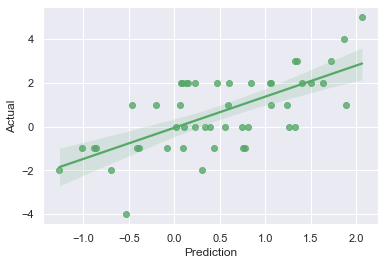

In [198]:
lgbmodel, train_preds, y_val_lgbm, y_val_preds = lgbm_model(X_train, y_train, X_val, y_val, red_data=False)
display_results(X=X_val, y_true=y_val_lgbm, y_pred=y_val_preds, model=lgbmodel)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:253: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "


Random Prediction: 
For rand val of 31, y_pred is [1.74784175] and y_true is 2


Metrics: 
R2 score (val) is 0.38221365495392623

Accuracy score, winner take all is 0.5918367346938775


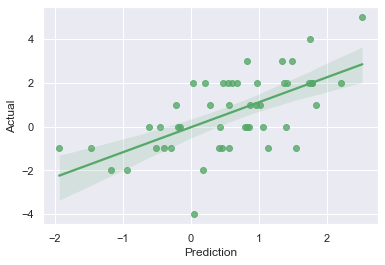

In [199]:
lgbmodel, train_preds, y_val_lgbm, y_val_preds = lgbm_model(X_train_red, y_train_red, X_val_red, y_val_red, red_data=True)
display_results(X=X_val_red, y_true=y_val_lgbm, y_pred=y_val_preds, model=lgbmodel)

In [ ]:
# Write function to maximize R2
def maximize_r2_lgbm(x):
    
    params = {'learning_rate': [0.001],
              'n_estimators': [int(round(x[0]))],
              'num_leaves': [int(round(x[1]))],
              'subsample': [1], 
              'colsample_bytree': [x[2]],
              'max_depth': [int(round(x[3]))]
             }
    
    lgbmodel, train_preds, y_val_lgbm, y_val_preds = lgbm_model(X_train_red, 
                                                                            y_train_red, 
                                                                            X_val_red, 
                                                                            y_val_red, 
                                                                            red_data=True,
                                                                            param_set=params)
    
    return 1-r2_score(y_val_lgbm, y_val_preds)

def maximize_r2_deepnn(x):
    
    deep_model, train_preds, y_val_deepnn, y_val_preds = deepnn_model(X_train_red, 
                                                                        y_train_red, 
                                                                        X_val_red, 
                                                                        y_val_red, 
                                                                        red_data=True, 
                                                                        param_set=None, 
                                                                        opt=True,
                                                                        x=x)
    print('R2: ', r2_score(y_val_deepnn, y_val_preds))
    
    return 1-r2_score(y_val_deepnn, y_val_preds)


In [201]:
tic = time()

bounds = [(100, 5000), (2, 50), (0.5, 1), (2, 50)]

# result = differential_evolution(maximize_r2_lgbm, bounds, seed=1, disp=True)

toc = time()
print('Elapsed time is {} minutes'.format((toc-tic)/60))
# print(result)

Elapsed time is 0.0 minutes


Random Prediction: 
For rand val of 41, y_pred is [0.12879055] and y_true is -2


Metrics: 
R2 score (val) is 0.3787454826475496

Accuracy score, winner take all is 0.5510204081632653


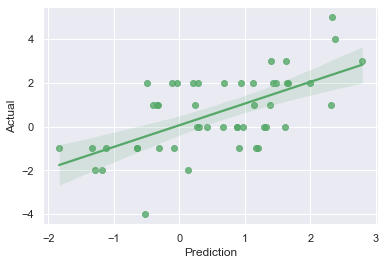

In [202]:
# Stash optimum results here so no need to re-run:
# n_estimators | num_leaves | colsample_bytree | max_depth
# gives r2 = 0.453 for validation set

opt_results_lgbm_full_data = {'learning_rate': 0.001,
                              'n_estimators': 4996,
                              'num_leaves': 42,
                              'subsample': 1, 
                              'colsample_bytree': 0.915,
                              'max_depth': 3
                             }

lgbmodel_opt, train_preds, y_val_lgbm, y_val_preds = lgbm_model(X_train, 
                                                            y_train, 
                                                            X_val, 
                                                            y_val, 
                                                            red_data=False, 
                                                            param_set=opt_results_lgbm_full_data, 
                                                            cv=False)

display_results(X=X_val, y_true=y_val_lgbm, y_pred=y_val_preds, model=lgbmodel_opt)


## Keras Dense Model

In [220]:
def deepnn_model(X_train, y_train, X_val, y_val, red_data, param_set=None, opt=False, x=None):

    y_train_deepnn = y_train.home_goals - y_train.away_goals
    y_val_deepnn = y_val.home_goals - y_val.away_goals
    
    sc = StandardScaler()
    
    X_train_sc = sc.fit_transform(X_train)
    X_val_sc = sc.fit_transform(X_val)
    
    if opt is True:
        '''
        x[0] is the number of layers
        x[1] is the number of hidden units in layer 1
        x[2] is the number of hidden units in layer 2
        x[3] is the number of hidden units in layer 3
        x[4] is the number of hidden units in layer 4
        x[5] is the number of hidden units in layer 5
        x[6] is dropout percentage, post layer 1
        x[7] is dropout percentage, post layer 2
        '''
        
        num_layers = int(round(x[0]))
        
               
        model = Sequential(name='fifa_deepnn')
        
        for i in range(num_layers):
            
            if i == 0:
                model.add(Dense(int(x[1]), activation='relu', input_shape=(X_train.shape[1],)))
                model.add(Dropout(x[6]))
            
            elif i == 1:
                model.add(Dense(int(x[2]), activation='relu', name='layer2'))
                model.add(Dropout(x[7]))
            
            elif i == 2:
                model.add(Dense(int(x[3]), activation='relu', name='layer3'))
            
            elif i == 3:
                model.add(Dense(int(x[4]), activation='relu', name='layer4'))
                
            elif i == 4:
                model.add(Dense(int(x[5]), activation='relu', name='layer5'))
                
        model.add(Dense(1, activation='linear', name='output_layer'))
    
        sgd = SGD(lr=0.001, decay=1e-6, momentum=0.98)
    
        model.compile(loss=['mean_squared_error'], optimizer=sgd, metrics=['mean_squared_error'])
        print(model.summary())
        model.fit(X_train_sc, y_train_deepnn, batch_size=X_train.shape[0], epochs=1000, verbose=False, validation_data=(X_val_sc, y_val_deepnn)) 
    
    else:
        model = Sequential(name='fifa_deepnn')
        model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
        model.add(Dropout(0.2))
        model.add(Dense(256, activation='relu', name='layer2'))
        model.add(Dropout(0.2))
        model.add(Dense(128, activation='relu', name='layer3'))
        model.add(Dense(64, activation='relu', name='layer4'))
        model.add(Dense(1, activation='linear', name='output_layer'))

        sgd = SGD(lr=0.001, decay=1e-6, momentum=0.98)

        model.compile(loss=['mean_squared_error'], optimizer=sgd, metrics=['mean_squared_error'])
        model.fit(X_train_sc, y_train_deepnn, batch_size=X_train.shape[0], epochs=1000, verbose=True, validation_data=(X_val_sc, y_val_deepnn))    
    
    train_preds = model.predict(X_train_sc)
    y_val_preds = model.predict(X_val_sc)
    
    return [model, train_preds, y_val_deepnn, y_val_preds]


In [221]:
deep_model, train_preds, y_val_deepnn, y_val_preds = deepnn_model(X_train, y_train, X_val, y_val, red_data=False, param_set=None)

Train on 274 samples, validate on 49 samples
Epoch 1/1000
274/274 [==============================] - 1s 3ms/step - loss: 4.6776 - mean_squared_error: 4.6776 - val_loss: 4.1169 - val_mean_squared_error: 4.1169
Epoch 2/1000
274/274 [==============================] - 0s 109us/step - loss: 4.4775 - mean_squared_error: 4.4775 - val_loss: 3.6459 - val_mean_squared_error: 3.6459
Epoch 3/1000
274/274 [==============================] - 0s 77us/step - loss: 3.9795 - mean_squared_error: 3.9795 - val_loss: 3.1809 - val_mean_squared_error: 3.1809
Epoch 4/1000
274/274 [==============================] - 0s 72us/step - loss: 3.7113 - mean_squared_error: 3.7113 - val_loss: 2.8266 - val_mean_squared_error: 2.8266
Epoch 5/1000
274/274 [==============================] - 0s 80us/step - loss: 3.7293 - mean_squared_error: 3.7293 - val_loss: 2.5958 - val_mean_squared_error: 2.5958
Epoch 6/1000
274/274 [==============================] - 0s 91us/step - loss: 3.7540 - mean_squared_error: 3.7540 - val_loss: 2.417

274/274 [==============================] - 0s 92us/step - loss: 1.0325 - mean_squared_error: 1.0325 - val_loss: 2.2690 - val_mean_squared_error: 2.2690
Epoch 51/1000
274/274 [==============================] - 0s 78us/step - loss: 0.9908 - mean_squared_error: 0.9908 - val_loss: 2.3080 - val_mean_squared_error: 2.3080
Epoch 52/1000
274/274 [==============================] - 0s 69us/step - loss: 1.0053 - mean_squared_error: 1.0053 - val_loss: 2.3153 - val_mean_squared_error: 2.3153
Epoch 53/1000
274/274 [==============================] - 0s 111us/step - loss: 0.9173 - mean_squared_error: 0.9173 - val_loss: 2.2976 - val_mean_squared_error: 2.2976
Epoch 54/1000
274/274 [==============================] - 0s 121us/step - loss: 0.8728 - mean_squared_error: 0.8728 - val_loss: 2.2597 - val_mean_squared_error: 2.2597
Epoch 55/1000
274/274 [==============================] - 0s 121us/step - loss: 0.8793 - mean_squared_error: 0.8793 - val_loss: 2.2132 - val_mean_squared_error: 2.2132
Epoch 56/1000
2

Epoch 100/1000
274/274 [==============================] - 0s 131us/step - loss: 0.2541 - mean_squared_error: 0.2541 - val_loss: 2.0951 - val_mean_squared_error: 2.0951
Epoch 101/1000
274/274 [==============================] - 0s 131us/step - loss: 0.2263 - mean_squared_error: 0.2263 - val_loss: 2.0923 - val_mean_squared_error: 2.0923
Epoch 102/1000
274/274 [==============================] - 0s 96us/step - loss: 0.2843 - mean_squared_error: 0.2843 - val_loss: 2.0935 - val_mean_squared_error: 2.0935
Epoch 103/1000
274/274 [==============================] - 0s 112us/step - loss: 0.3061 - mean_squared_error: 0.3061 - val_loss: 2.0977 - val_mean_squared_error: 2.0977
Epoch 104/1000
274/274 [==============================] - 0s 125us/step - loss: 0.2846 - mean_squared_error: 0.2846 - val_loss: 2.1014 - val_mean_squared_error: 2.1014
Epoch 105/1000
274/274 [==============================] - 0s 130us/step - loss: 0.3126 - mean_squared_error: 0.3126 - val_loss: 2.1078 - val_mean_squared_error: 

Epoch 149/1000
274/274 [==============================] - 0s 91us/step - loss: 0.1689 - mean_squared_error: 0.1689 - val_loss: 2.1329 - val_mean_squared_error: 2.1329
Epoch 150/1000
274/274 [==============================] - 0s 95us/step - loss: 0.1663 - mean_squared_error: 0.1663 - val_loss: 2.1140 - val_mean_squared_error: 2.1140
Epoch 151/1000
274/274 [==============================] - 0s 86us/step - loss: 0.1772 - mean_squared_error: 0.1772 - val_loss: 2.0988 - val_mean_squared_error: 2.0988
Epoch 152/1000
274/274 [==============================] - 0s 105us/step - loss: 0.1726 - mean_squared_error: 0.1726 - val_loss: 2.0891 - val_mean_squared_error: 2.0891
Epoch 153/1000
274/274 [==============================] - 0s 99us/step - loss: 0.1601 - mean_squared_error: 0.1601 - val_loss: 2.0830 - val_mean_squared_error: 2.0830
Epoch 154/1000
274/274 [==============================] - 0s 142us/step - loss: 0.1561 - mean_squared_error: 0.1561 - val_loss: 2.0796 - val_mean_squared_error: 2.0

Epoch 198/1000
274/274 [==============================] - 0s 107us/step - loss: 0.1250 - mean_squared_error: 0.1250 - val_loss: 2.2148 - val_mean_squared_error: 2.2148
Epoch 199/1000
274/274 [==============================] - 0s 100us/step - loss: 0.1257 - mean_squared_error: 0.1257 - val_loss: 2.2055 - val_mean_squared_error: 2.2055
Epoch 200/1000
274/274 [==============================] - 0s 95us/step - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 2.1969 - val_mean_squared_error: 2.1969
Epoch 201/1000
274/274 [==============================] - 0s 126us/step - loss: 0.1536 - mean_squared_error: 0.1536 - val_loss: 2.1885 - val_mean_squared_error: 2.1885
Epoch 202/1000
274/274 [==============================] - 0s 128us/step - loss: 0.1251 - mean_squared_error: 0.1251 - val_loss: 2.1819 - val_mean_squared_error: 2.1819
Epoch 203/1000
274/274 [==============================] - 0s 136us/step - loss: 0.1012 - mean_squared_error: 0.1012 - val_loss: 2.1759 - val_mean_squared_error: 

Epoch 247/1000
274/274 [==============================] - 0s 109us/step - loss: 0.0959 - mean_squared_error: 0.0959 - val_loss: 2.2389 - val_mean_squared_error: 2.2389
Epoch 248/1000
274/274 [==============================] - 0s 112us/step - loss: 0.1204 - mean_squared_error: 0.1204 - val_loss: 2.2394 - val_mean_squared_error: 2.2394
Epoch 249/1000
274/274 [==============================] - 0s 130us/step - loss: 0.1387 - mean_squared_error: 0.1387 - val_loss: 2.2370 - val_mean_squared_error: 2.2370
Epoch 250/1000
274/274 [==============================] - 0s 126us/step - loss: 0.0955 - mean_squared_error: 0.0955 - val_loss: 2.2325 - val_mean_squared_error: 2.2325
Epoch 251/1000
274/274 [==============================] - 0s 110us/step - loss: 0.1138 - mean_squared_error: 0.1138 - val_loss: 2.2261 - val_mean_squared_error: 2.2261
Epoch 252/1000
274/274 [==============================] - 0s 125us/step - loss: 0.1266 - mean_squared_error: 0.1266 - val_loss: 2.2179 - val_mean_squared_error:

Epoch 296/1000
274/274 [==============================] - 0s 120us/step - loss: 0.0866 - mean_squared_error: 0.0866 - val_loss: 2.1719 - val_mean_squared_error: 2.1719
Epoch 297/1000
274/274 [==============================] - 0s 128us/step - loss: 0.0884 - mean_squared_error: 0.0884 - val_loss: 2.1767 - val_mean_squared_error: 2.1767
Epoch 298/1000
274/274 [==============================] - 0s 128us/step - loss: 0.0937 - mean_squared_error: 0.0937 - val_loss: 2.1805 - val_mean_squared_error: 2.1805
Epoch 299/1000
274/274 [==============================] - 0s 111us/step - loss: 0.1039 - mean_squared_error: 0.1039 - val_loss: 2.1844 - val_mean_squared_error: 2.1844
Epoch 300/1000
274/274 [==============================] - 0s 129us/step - loss: 0.1122 - mean_squared_error: 0.1122 - val_loss: 2.1863 - val_mean_squared_error: 2.1863
Epoch 301/1000
274/274 [==============================] - 0s 113us/step - loss: 0.0968 - mean_squared_error: 0.0968 - val_loss: 2.1859 - val_mean_squared_error:

Epoch 345/1000
274/274 [==============================] - 0s 88us/step - loss: 0.0992 - mean_squared_error: 0.0992 - val_loss: 2.1578 - val_mean_squared_error: 2.1578
Epoch 346/1000
274/274 [==============================] - 0s 85us/step - loss: 0.0874 - mean_squared_error: 0.0874 - val_loss: 2.1617 - val_mean_squared_error: 2.1617
Epoch 347/1000
274/274 [==============================] - 0s 66us/step - loss: 0.0720 - mean_squared_error: 0.0720 - val_loss: 2.1660 - val_mean_squared_error: 2.1660
Epoch 348/1000
274/274 [==============================] - 0s 109us/step - loss: 0.0942 - mean_squared_error: 0.0942 - val_loss: 2.1699 - val_mean_squared_error: 2.1699
Epoch 349/1000
274/274 [==============================] - 0s 110us/step - loss: 0.0790 - mean_squared_error: 0.0790 - val_loss: 2.1734 - val_mean_squared_error: 2.1734
Epoch 350/1000
274/274 [==============================] - 0s 104us/step - loss: 0.0868 - mean_squared_error: 0.0868 - val_loss: 2.1767 - val_mean_squared_error: 2.

Epoch 394/1000
274/274 [==============================] - 0s 116us/step - loss: 0.0840 - mean_squared_error: 0.0840 - val_loss: 2.1604 - val_mean_squared_error: 2.1604
Epoch 395/1000
274/274 [==============================] - 0s 114us/step - loss: 0.0799 - mean_squared_error: 0.0799 - val_loss: 2.1646 - val_mean_squared_error: 2.1646
Epoch 396/1000
274/274 [==============================] - 0s 119us/step - loss: 0.0791 - mean_squared_error: 0.0791 - val_loss: 2.1697 - val_mean_squared_error: 2.1697
Epoch 397/1000
274/274 [==============================] - 0s 125us/step - loss: 0.0784 - mean_squared_error: 0.0784 - val_loss: 2.1760 - val_mean_squared_error: 2.1760
Epoch 398/1000
274/274 [==============================] - 0s 128us/step - loss: 0.0994 - mean_squared_error: 0.0994 - val_loss: 2.1834 - val_mean_squared_error: 2.1834
Epoch 399/1000
274/274 [==============================] - 0s 120us/step - loss: 0.0993 - mean_squared_error: 0.0993 - val_loss: 2.1918 - val_mean_squared_error:

Epoch 443/1000
274/274 [==============================] - 0s 135us/step - loss: 0.0713 - mean_squared_error: 0.0713 - val_loss: 2.1836 - val_mean_squared_error: 2.1836
Epoch 444/1000
274/274 [==============================] - 0s 116us/step - loss: 0.0892 - mean_squared_error: 0.0892 - val_loss: 2.1809 - val_mean_squared_error: 2.1809
Epoch 445/1000
274/274 [==============================] - 0s 113us/step - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 2.1785 - val_mean_squared_error: 2.1785
Epoch 446/1000
274/274 [==============================] - 0s 109us/step - loss: 0.0831 - mean_squared_error: 0.0831 - val_loss: 2.1768 - val_mean_squared_error: 2.1768
Epoch 447/1000
274/274 [==============================] - 0s 120us/step - loss: 0.0889 - mean_squared_error: 0.0889 - val_loss: 2.1754 - val_mean_squared_error: 2.1754
Epoch 448/1000
274/274 [==============================] - 0s 125us/step - loss: 0.0814 - mean_squared_error: 0.0814 - val_loss: 2.1736 - val_mean_squared_error:

Epoch 492/1000
274/274 [==============================] - 0s 114us/step - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 2.1495 - val_mean_squared_error: 2.1495
Epoch 493/1000
274/274 [==============================] - 0s 131us/step - loss: 0.0685 - mean_squared_error: 0.0685 - val_loss: 2.1537 - val_mean_squared_error: 2.1537
Epoch 494/1000
274/274 [==============================] - 0s 124us/step - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 2.1572 - val_mean_squared_error: 2.1572
Epoch 495/1000
274/274 [==============================] - 0s 119us/step - loss: 0.0776 - mean_squared_error: 0.0776 - val_loss: 2.1610 - val_mean_squared_error: 2.1610
Epoch 496/1000
274/274 [==============================] - 0s 121us/step - loss: 0.0790 - mean_squared_error: 0.0790 - val_loss: 2.1646 - val_mean_squared_error: 2.1646
Epoch 497/1000
274/274 [==============================] - 0s 112us/step - loss: 0.0800 - mean_squared_error: 0.0800 - val_loss: 2.1681 - val_mean_squared_error:

Epoch 541/1000
274/274 [==============================] - 0s 134us/step - loss: 0.0685 - mean_squared_error: 0.0685 - val_loss: 2.1754 - val_mean_squared_error: 2.1754
Epoch 542/1000
274/274 [==============================] - 0s 126us/step - loss: 0.0598 - mean_squared_error: 0.0598 - val_loss: 2.1757 - val_mean_squared_error: 2.1757
Epoch 543/1000
274/274 [==============================] - 0s 116us/step - loss: 0.0782 - mean_squared_error: 0.0782 - val_loss: 2.1753 - val_mean_squared_error: 2.1753
Epoch 544/1000
274/274 [==============================] - 0s 125us/step - loss: 0.0744 - mean_squared_error: 0.0744 - val_loss: 2.1744 - val_mean_squared_error: 2.1744
Epoch 545/1000
274/274 [==============================] - 0s 116us/step - loss: 0.0704 - mean_squared_error: 0.0704 - val_loss: 2.1728 - val_mean_squared_error: 2.1728
Epoch 546/1000
274/274 [==============================] - 0s 118us/step - loss: 0.0831 - mean_squared_error: 0.0831 - val_loss: 2.1705 - val_mean_squared_error:

Epoch 590/1000
274/274 [==============================] - 0s 116us/step - loss: 0.0679 - mean_squared_error: 0.0679 - val_loss: 2.1504 - val_mean_squared_error: 2.1504
Epoch 591/1000
274/274 [==============================] - 0s 116us/step - loss: 0.0680 - mean_squared_error: 0.0680 - val_loss: 2.1495 - val_mean_squared_error: 2.1495
Epoch 592/1000
274/274 [==============================] - 0s 115us/step - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 2.1494 - val_mean_squared_error: 2.1494
Epoch 593/1000
274/274 [==============================] - 0s 130us/step - loss: 0.0546 - mean_squared_error: 0.0546 - val_loss: 2.1497 - val_mean_squared_error: 2.1497
Epoch 594/1000
274/274 [==============================] - 0s 138us/step - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 2.1504 - val_mean_squared_error: 2.1504
Epoch 595/1000
274/274 [==============================] - 0s 123us/step - loss: 0.0647 - mean_squared_error: 0.0647 - val_loss: 2.1513 - val_mean_squared_error:

Epoch 639/1000
274/274 [==============================] - 0s 90us/step - loss: 0.0761 - mean_squared_error: 0.0761 - val_loss: 2.1454 - val_mean_squared_error: 2.1454
Epoch 640/1000
274/274 [==============================] - 0s 85us/step - loss: 0.0822 - mean_squared_error: 0.0822 - val_loss: 2.1468 - val_mean_squared_error: 2.1468
Epoch 641/1000
274/274 [==============================] - 0s 137us/step - loss: 0.0694 - mean_squared_error: 0.0694 - val_loss: 2.1490 - val_mean_squared_error: 2.1490
Epoch 642/1000
274/274 [==============================] - 0s 121us/step - loss: 0.0572 - mean_squared_error: 0.0572 - val_loss: 2.1515 - val_mean_squared_error: 2.1515
Epoch 643/1000
274/274 [==============================] - 0s 125us/step - loss: 0.0673 - mean_squared_error: 0.0673 - val_loss: 2.1546 - val_mean_squared_error: 2.1546
Epoch 644/1000
274/274 [==============================] - 0s 111us/step - loss: 0.0566 - mean_squared_error: 0.0566 - val_loss: 2.1584 - val_mean_squared_error: 2

Epoch 688/1000
274/274 [==============================] - 0s 85us/step - loss: 0.0688 - mean_squared_error: 0.0688 - val_loss: 2.1512 - val_mean_squared_error: 2.1512
Epoch 689/1000
274/274 [==============================] - 0s 126us/step - loss: 0.0646 - mean_squared_error: 0.0646 - val_loss: 2.1520 - val_mean_squared_error: 2.1520
Epoch 690/1000
274/274 [==============================] - 0s 117us/step - loss: 0.0597 - mean_squared_error: 0.0597 - val_loss: 2.1530 - val_mean_squared_error: 2.1530
Epoch 691/1000
274/274 [==============================] - 0s 114us/step - loss: 0.0608 - mean_squared_error: 0.0608 - val_loss: 2.1533 - val_mean_squared_error: 2.1533
Epoch 692/1000
274/274 [==============================] - 0s 133us/step - loss: 0.0698 - mean_squared_error: 0.0698 - val_loss: 2.1533 - val_mean_squared_error: 2.1533
Epoch 693/1000
274/274 [==============================] - 0s 114us/step - loss: 0.0579 - mean_squared_error: 0.0579 - val_loss: 2.1533 - val_mean_squared_error: 

Epoch 737/1000
274/274 [==============================] - 0s 80us/step - loss: 0.0701 - mean_squared_error: 0.0701 - val_loss: 2.1770 - val_mean_squared_error: 2.1770
Epoch 738/1000
274/274 [==============================] - 0s 125us/step - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 2.1747 - val_mean_squared_error: 2.1747
Epoch 739/1000
274/274 [==============================] - 0s 123us/step - loss: 0.0591 - mean_squared_error: 0.0591 - val_loss: 2.1721 - val_mean_squared_error: 2.1721
Epoch 740/1000
274/274 [==============================] - 0s 129us/step - loss: 0.0575 - mean_squared_error: 0.0575 - val_loss: 2.1690 - val_mean_squared_error: 2.1690
Epoch 741/1000
274/274 [==============================] - 0s 122us/step - loss: 0.0557 - mean_squared_error: 0.0557 - val_loss: 2.1659 - val_mean_squared_error: 2.1659
Epoch 742/1000
274/274 [==============================] - 0s 114us/step - loss: 0.0581 - mean_squared_error: 0.0581 - val_loss: 2.1630 - val_mean_squared_error: 

Epoch 786/1000
274/274 [==============================] - 0s 122us/step - loss: 0.0686 - mean_squared_error: 0.0686 - val_loss: 2.1718 - val_mean_squared_error: 2.1718
Epoch 787/1000
274/274 [==============================] - 0s 112us/step - loss: 0.0645 - mean_squared_error: 0.0645 - val_loss: 2.1742 - val_mean_squared_error: 2.1742
Epoch 788/1000
274/274 [==============================] - 0s 83us/step - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 2.1770 - val_mean_squared_error: 2.1770
Epoch 789/1000
274/274 [==============================] - 0s 89us/step - loss: 0.0648 - mean_squared_error: 0.0648 - val_loss: 2.1788 - val_mean_squared_error: 2.1788
Epoch 790/1000
274/274 [==============================] - 0s 117us/step - loss: 0.0640 - mean_squared_error: 0.0640 - val_loss: 2.1794 - val_mean_squared_error: 2.1794
Epoch 791/1000
274/274 [==============================] - 0s 121us/step - loss: 0.0743 - mean_squared_error: 0.0743 - val_loss: 2.1785 - val_mean_squared_error: 2

Epoch 835/1000
274/274 [==============================] - 0s 121us/step - loss: 0.0620 - mean_squared_error: 0.0620 - val_loss: 2.1805 - val_mean_squared_error: 2.1805
Epoch 836/1000
274/274 [==============================] - 0s 125us/step - loss: 0.0653 - mean_squared_error: 0.0653 - val_loss: 2.1811 - val_mean_squared_error: 2.1811
Epoch 837/1000
274/274 [==============================] - 0s 116us/step - loss: 0.0659 - mean_squared_error: 0.0659 - val_loss: 2.1816 - val_mean_squared_error: 2.1816
Epoch 838/1000
274/274 [==============================] - 0s 115us/step - loss: 0.0542 - mean_squared_error: 0.0542 - val_loss: 2.1816 - val_mean_squared_error: 2.1816
Epoch 839/1000
274/274 [==============================] - 0s 126us/step - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 2.1819 - val_mean_squared_error: 2.1819
Epoch 840/1000
274/274 [==============================] - 0s 119us/step - loss: 0.0648 - mean_squared_error: 0.0648 - val_loss: 2.1817 - val_mean_squared_error:

Epoch 884/1000
274/274 [==============================] - 0s 133us/step - loss: 0.0691 - mean_squared_error: 0.0691 - val_loss: 2.1620 - val_mean_squared_error: 2.1620
Epoch 885/1000
274/274 [==============================] - 0s 120us/step - loss: 0.0607 - mean_squared_error: 0.0607 - val_loss: 2.1660 - val_mean_squared_error: 2.1660
Epoch 886/1000
274/274 [==============================] - 0s 123us/step - loss: 0.0487 - mean_squared_error: 0.0487 - val_loss: 2.1700 - val_mean_squared_error: 2.1700
Epoch 887/1000
274/274 [==============================] - 0s 126us/step - loss: 0.0699 - mean_squared_error: 0.0699 - val_loss: 2.1737 - val_mean_squared_error: 2.1737
Epoch 888/1000
274/274 [==============================] - 0s 122us/step - loss: 0.0556 - mean_squared_error: 0.0556 - val_loss: 2.1772 - val_mean_squared_error: 2.1772
Epoch 889/1000
274/274 [==============================] - 0s 110us/step - loss: 0.0612 - mean_squared_error: 0.0612 - val_loss: 2.1789 - val_mean_squared_error:

Epoch 933/1000
274/274 [==============================] - 0s 109us/step - loss: 0.0582 - mean_squared_error: 0.0582 - val_loss: 2.1465 - val_mean_squared_error: 2.1465
Epoch 934/1000
274/274 [==============================] - 0s 107us/step - loss: 0.0596 - mean_squared_error: 0.0596 - val_loss: 2.1437 - val_mean_squared_error: 2.1437
Epoch 935/1000
274/274 [==============================] - 0s 136us/step - loss: 0.0537 - mean_squared_error: 0.0537 - val_loss: 2.1426 - val_mean_squared_error: 2.1426
Epoch 936/1000
274/274 [==============================] - 0s 123us/step - loss: 0.0570 - mean_squared_error: 0.0570 - val_loss: 2.1423 - val_mean_squared_error: 2.1423
Epoch 937/1000
274/274 [==============================] - 0s 128us/step - loss: 0.0499 - mean_squared_error: 0.0499 - val_loss: 2.1428 - val_mean_squared_error: 2.1428
Epoch 938/1000
274/274 [==============================] - 0s 120us/step - loss: 0.0604 - mean_squared_error: 0.0604 - val_loss: 2.1446 - val_mean_squared_error:

Epoch 982/1000
274/274 [==============================] - 0s 89us/step - loss: 0.0644 - mean_squared_error: 0.0644 - val_loss: 2.1720 - val_mean_squared_error: 2.1720
Epoch 983/1000
274/274 [==============================] - 0s 101us/step - loss: 0.0536 - mean_squared_error: 0.0536 - val_loss: 2.1697 - val_mean_squared_error: 2.1697
Epoch 984/1000
274/274 [==============================] - 0s 95us/step - loss: 0.0584 - mean_squared_error: 0.0584 - val_loss: 2.1663 - val_mean_squared_error: 2.1663
Epoch 985/1000
274/274 [==============================] - 0s 78us/step - loss: 0.0603 - mean_squared_error: 0.0603 - val_loss: 2.1625 - val_mean_squared_error: 2.1625
Epoch 986/1000
274/274 [==============================] - 0s 91us/step - loss: 0.0698 - mean_squared_error: 0.0698 - val_loss: 2.1577 - val_mean_squared_error: 2.1577
Epoch 987/1000
274/274 [==============================] - 0s 106us/step - loss: 0.0652 - mean_squared_error: 0.0652 - val_loss: 2.1534 - val_mean_squared_error: 2.1


Metrics: 
R2 score (val) is 0.3142105837402145

Accuracy score, winner take all is 0.6326530612244898


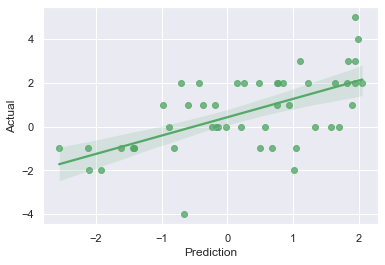

In [212]:
display_results(X=X_val, y_true=y_val_deepnn, y_pred=y_val_preds, model=deepnn_model, scale_results=True)

In [213]:
r2_score(y_train.home_goals - y_train.away_goals, train_preds)

0.9921690110094002

### Attempt to Optimize DeepNN Architecture with Differential Evolution

In [231]:
tic = time()
'''
x[0] is the number of layers
x[1] is the number of hidden units in layer 1
x[2] is the number of hidden units in layer 2
x[3] is the number of hidden units in layer 3
x[4] is the number of hidden units in layer 4
x[5] is the number of hidden units in layer 5
x[6] is dropout percentage, post layer 1
x[7] is dropout percentage, post layer 2
'''

bounds = [(2, 5), (50, 1000), (50, 500), (10, 250), (10, 125), (10, 65), (0, 0.5), (0, 0.5)]
initial_guess = [3, 100, 100, 100, 50, 30, 0.3, 0.3]

# result = differential_evolution(maximize_r2_deepnn, bounds=bounds, seed=1, disp=True)
result = basinhopping(maximize_r2_deepnn, x0=initial_guess)

toc = time()
print('Elapsed time is {} minutes'.format((toc-tic)/60))
print(result)

Model: "fifa_deepnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1042 (Dense)           (None, 100)               19000     
_________________________________________________________________
dropout_2083 (Dropout)       (None, 100)               0         
_________________________________________________________________
layer2 (Dense)               (None, 100)               10100     
_________________________________________________________________
dropout_2084 (Dropout)       (None, 100)               0         
_________________________________________________________________
layer3 (Dense)               (None, 100)               10100     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 101       
Total params: 39,301
Trainable params: 39,301
Non-trainable params: 0
___________________________________________________

KeyboardInterrupt: 

In [226]:
# maximize_r2_deepnn(x=z)
result

74    m. özil
Name: Name, dtype: object

 ## Preprocessing Steps for Final Model
 1. Download video clip of ~20 seconds before goal/goal-scoring change is attained
 2. Identify the scoring team
 3. Localize position of the involved players relative to some reference point
 4. Localize ball position
 5. Map from 3D clip to 2D space